In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from skimage import data, color, feature
import skimage.data
from sklearn.datasets import fetch_lfw_people

In [13]:
# get images with faces
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [14]:
# get images without faces
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']

images = [color.rgb2gray(getattr(data, name)()) # Compute luminance of an RGB image for each image
          for name in imgs_to_use]



C:\Users\lewiis\AppData\Local\Temp/ipykernel_11088/1340641997.py:8: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)()) # Compute luminance of an RGB image for each image


In [15]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0,
                    patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

In [16]:
from itertools import chain

X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches, negative_patches)]) # extract histograms of oriented gradients

y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1 # imgaes with faces are marked as 1

In [25]:
# model
from sklearn.svm import LinearSVC
model = LinearSVC(C=4, max_iter=100000)

model.fit(X_train, y_train)

C:\Users\lewiis\anaconda3\envs\deep_learning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=4)

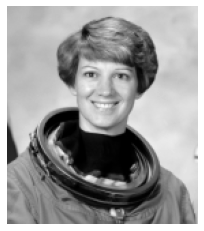

In [26]:
# take a test image
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]
plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [27]:
#
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale*s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

In [28]:
labels = model.predict(patches_hog)
labels.sum()

55.0

In [29]:
indices

((0, 0),
 (0, 2),
 (0, 4),
 (0, 6),
 (0, 8),
 (0, 10),
 (0, 12),
 (0, 14),
 (0, 16),
 (0, 18),
 (0, 20),
 (0, 22),
 (0, 24),
 (0, 26),
 (0, 28),
 (0, 30),
 (0, 32),
 (0, 34),
 (0, 36),
 (0, 38),
 (0, 40),
 (0, 42),
 (0, 44),
 (0, 46),
 (0, 48),
 (0, 50),
 (0, 52),
 (0, 54),
 (0, 56),
 (0, 58),
 (0, 60),
 (0, 62),
 (0, 64),
 (0, 66),
 (0, 68),
 (0, 70),
 (0, 72),
 (0, 74),
 (0, 76),
 (2, 0),
 (2, 2),
 (2, 4),
 (2, 6),
 (2, 8),
 (2, 10),
 (2, 12),
 (2, 14),
 (2, 16),
 (2, 18),
 (2, 20),
 (2, 22),
 (2, 24),
 (2, 26),
 (2, 28),
 (2, 30),
 (2, 32),
 (2, 34),
 (2, 36),
 (2, 38),
 (2, 40),
 (2, 42),
 (2, 44),
 (2, 46),
 (2, 48),
 (2, 50),
 (2, 52),
 (2, 54),
 (2, 56),
 (2, 58),
 (2, 60),
 (2, 62),
 (2, 64),
 (2, 66),
 (2, 68),
 (2, 70),
 (2, 72),
 (2, 74),
 (2, 76),
 (4, 0),
 (4, 2),
 (4, 4),
 (4, 6),
 (4, 8),
 (4, 10),
 (4, 12),
 (4, 14),
 (4, 16),
 (4, 18),
 (4, 20),
 (4, 22),
 (4, 24),
 (4, 26),
 (4, 28),
 (4, 30),
 (4, 32),
 (4, 34),
 (4, 36),
 (4, 38),
 (4, 40),
 (4, 42),
 (4, 44),
 (4, 

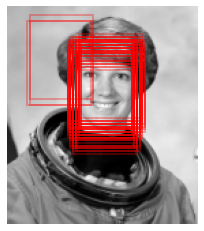

In [39]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')
Ni, Nj = positive_patches[1].shape
indices = np.array(indices)

i_ind = []
j_ind = []
for i, j in indices[labels==1]:
    i_ind.append(i)
    j_ind.append(j)

i_ind = np.array(i_ind)
j_ind = np.array(j_ind)

for i, j in indices[labels==1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))
# ax.add_patch(plt.Rectangle((i_ind.mean(), j_ind.mean()), Nj, Ni, edgecolor='red', alpha=0.5, lw=3, facecolor='none'))

# for i, j in indices[labels == 1]:
#     ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
#                                alpha=0.3, lw=2,
#                                facecolor='none'))